# Getting started with PyMC3 - Demo

This notebook was used to test most basic funcionalities from PyMC3 ([source](https://docs.pymc.io/notebooks/getting_started.html))

The link with correct instruction to install PyMC3 on Mac ([here](https://discourse.pymc.io/t/pymc3-installation-issue/7068/2))

**Remember**: from the current stage, PyMC3 samplers (that generates teh traces) don't work within py files (VS Code), only through Jupyter Notebooks

In [1]:
# %%
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
# %%
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

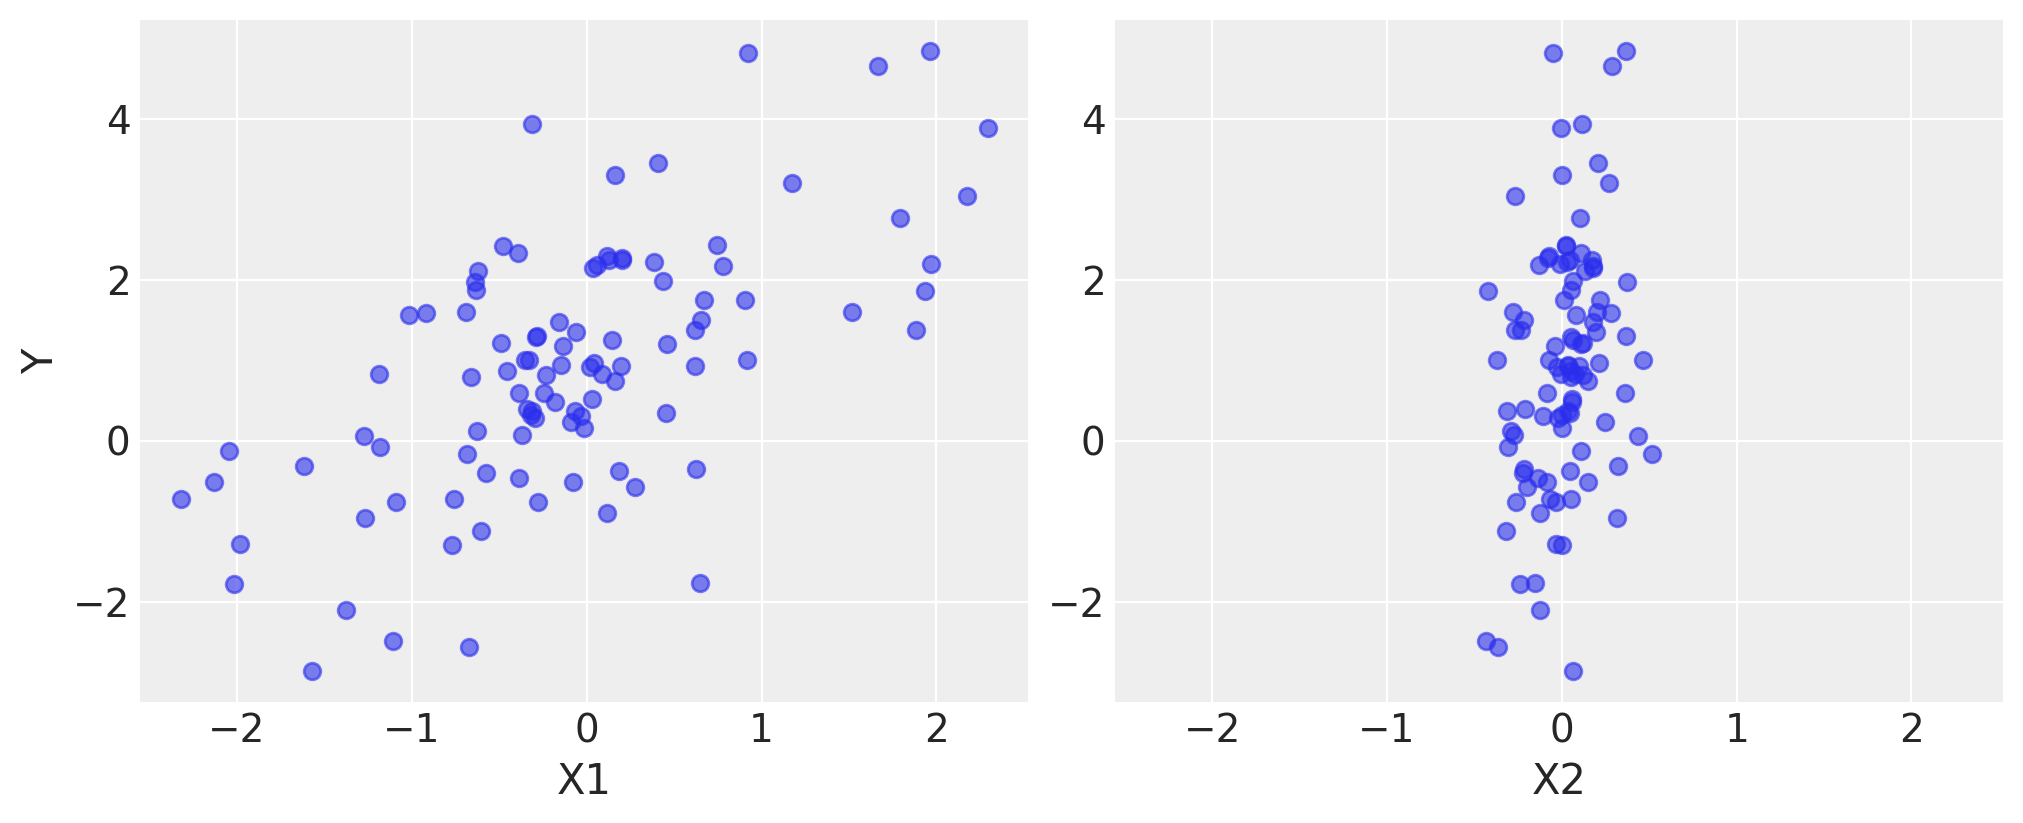

In [2]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + np.random.randn(size) * sigma
# %%
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [3]:
import pymc3 as pm
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.2


In [10]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [11]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'alpha': array(0.95724679),
 'beta': array([1.10071814, 2.9511438 ]),
 'sigma_log__': array(0.03540151),
 'sigma': array(1.0360356)}

In [12]:
map_estimate = pm.find_MAP(model=basic_model, method="powell")
map_estimate

/opt/anaconda3/envs/pymc3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method powell does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


{'alpha': array(0.95835519),
 'beta': array([1.1017629 , 2.95394057]),
 'sigma_log__': array(0.03638187),
 'sigma': array(1.03705179)}

In [13]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 13 seconds.


In [14]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 16 seconds.


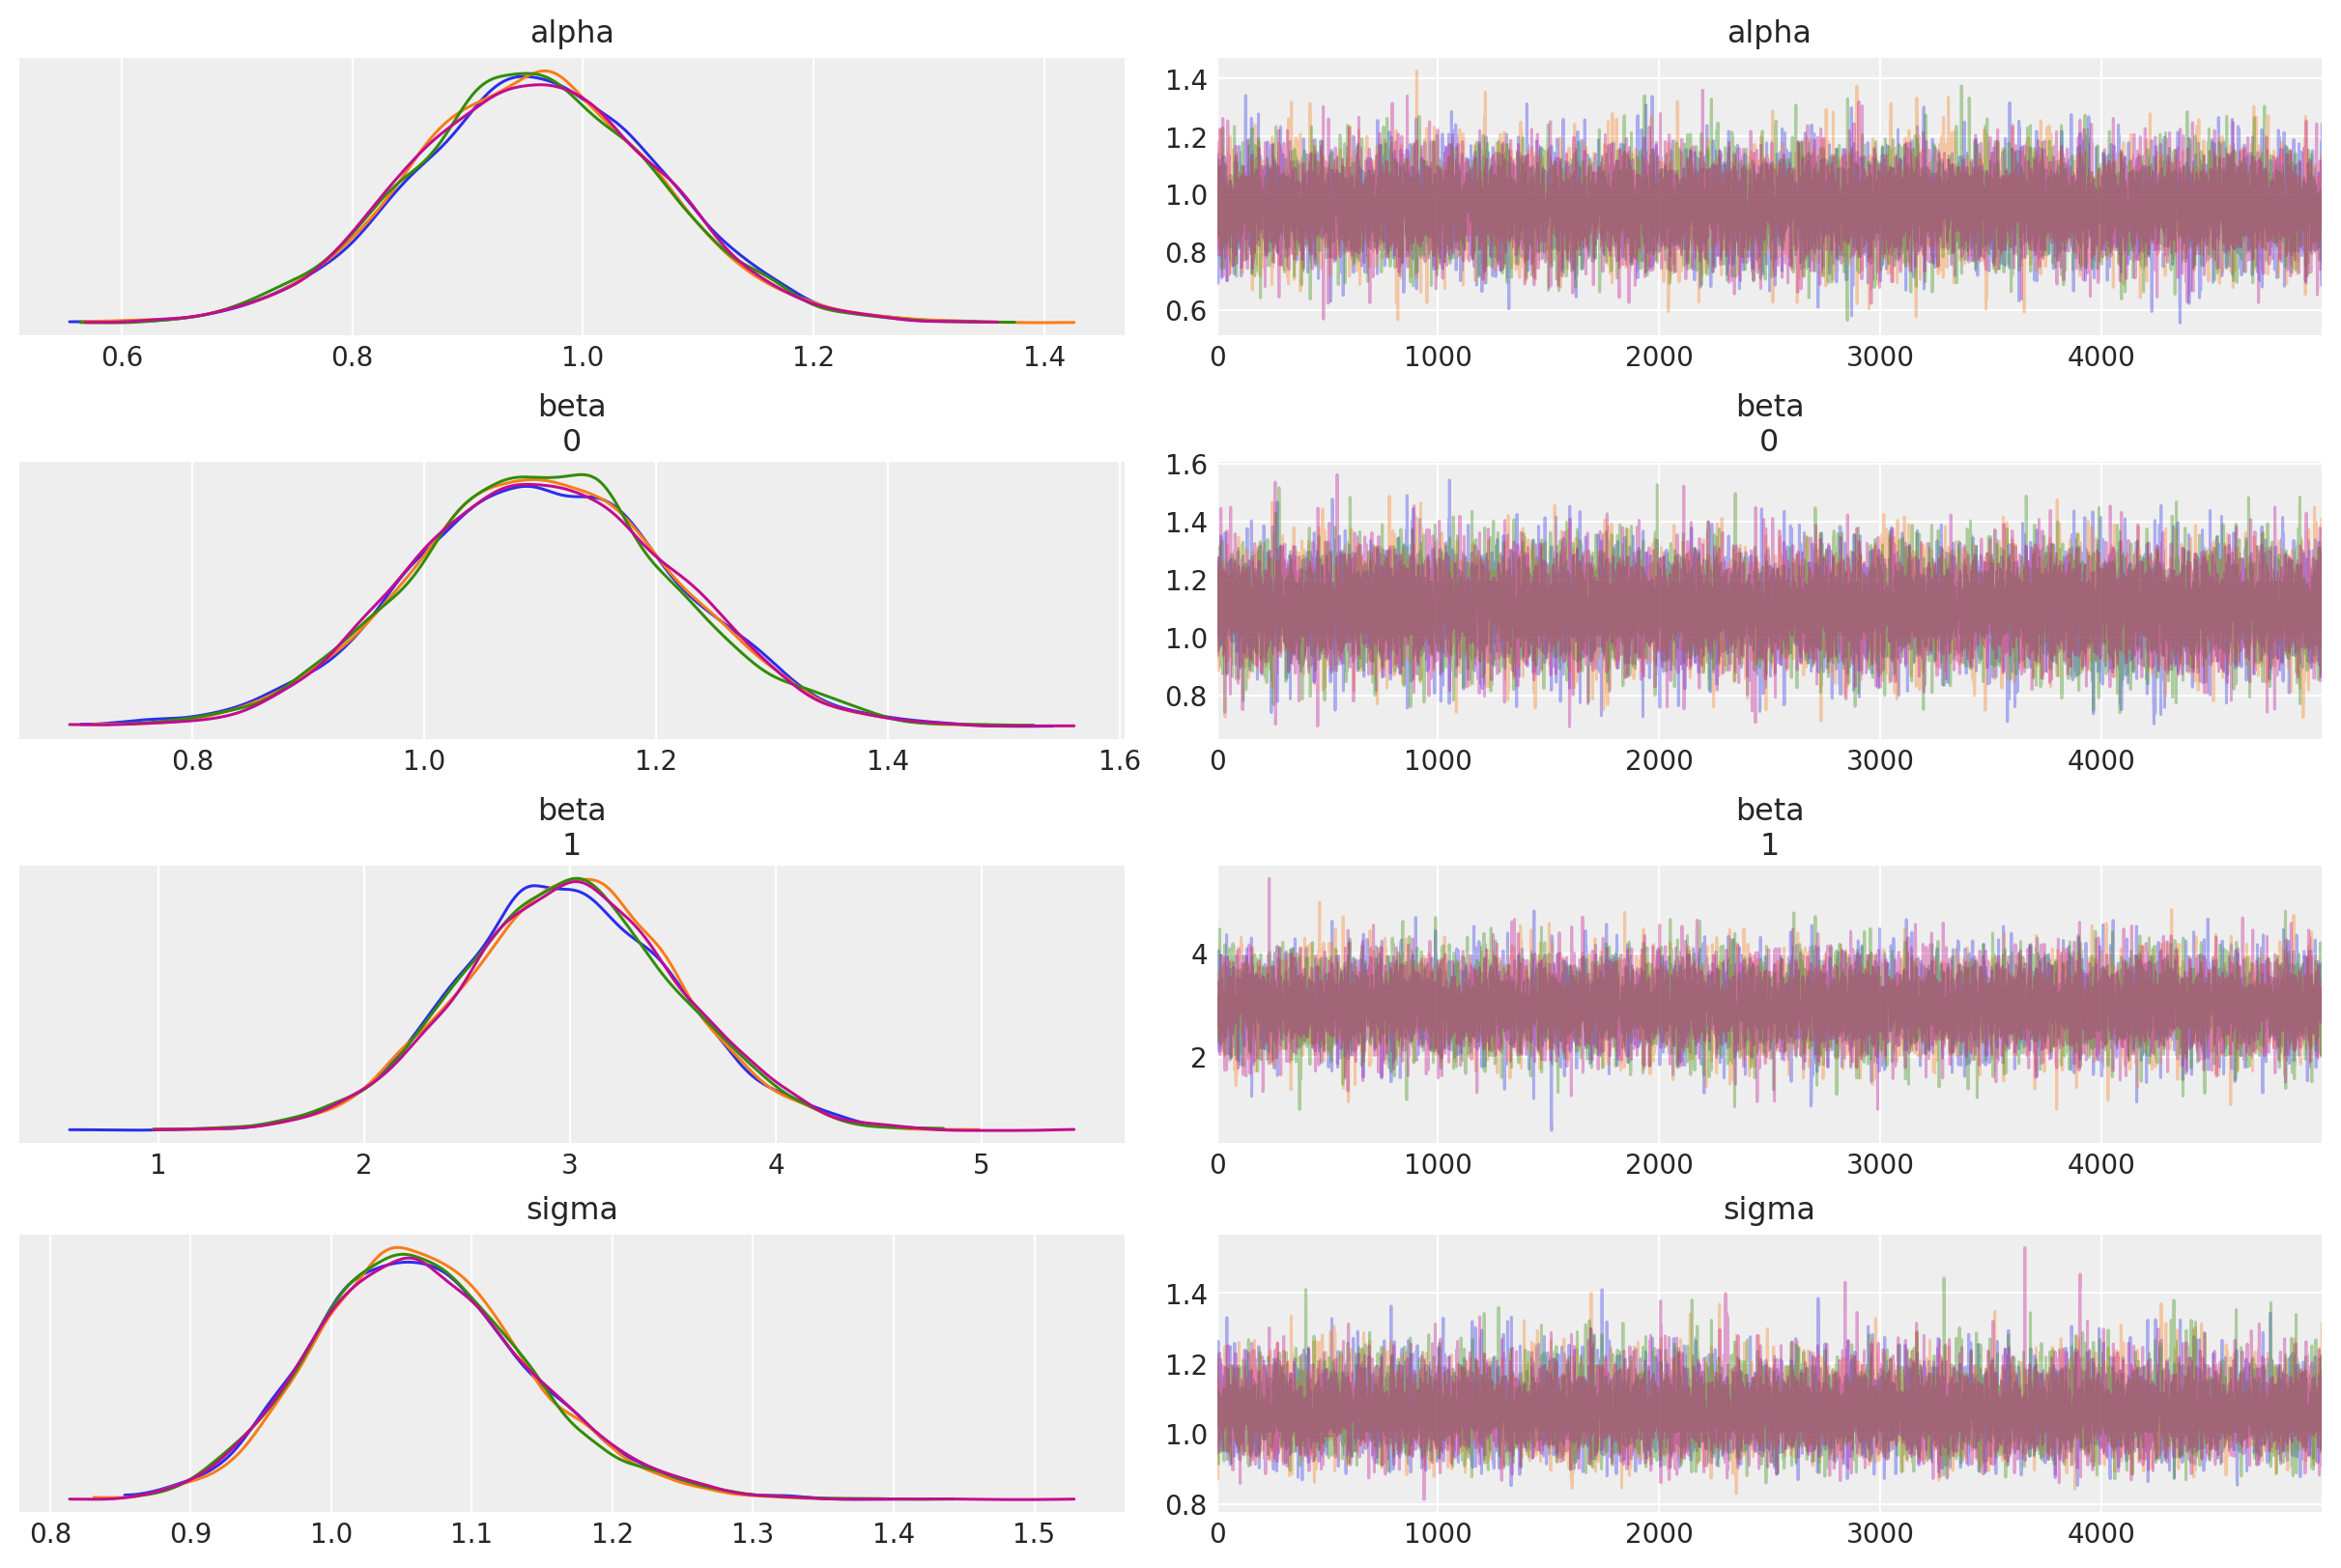

In [18]:
with basic_model:
    az.plot_trace(trace, compact=False);

In [19]:
with basic_model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.96,0.11,0.75,1.16,0.0,0.0,18612.84,14459.04,1.0
beta[0],1.10,0.11,0.89,1.31,0.0,0.0,19554.93,14656.50,1.0
beta[1],2.99,0.53,2.01,4.01,0.0,0.0,16059.65,12080.57,1.0
sigma,1.07,0.08,0.93,1.22,0.0,0.0,18665.69,14253.56,1.0


In [20]:
import pandas as pd

returns = pd.read_csv(
    pm.get_data("SP500.csv"), parse_dates=True, index_col=0, usecols=["Date", "change"]
)
len(returns)

2906

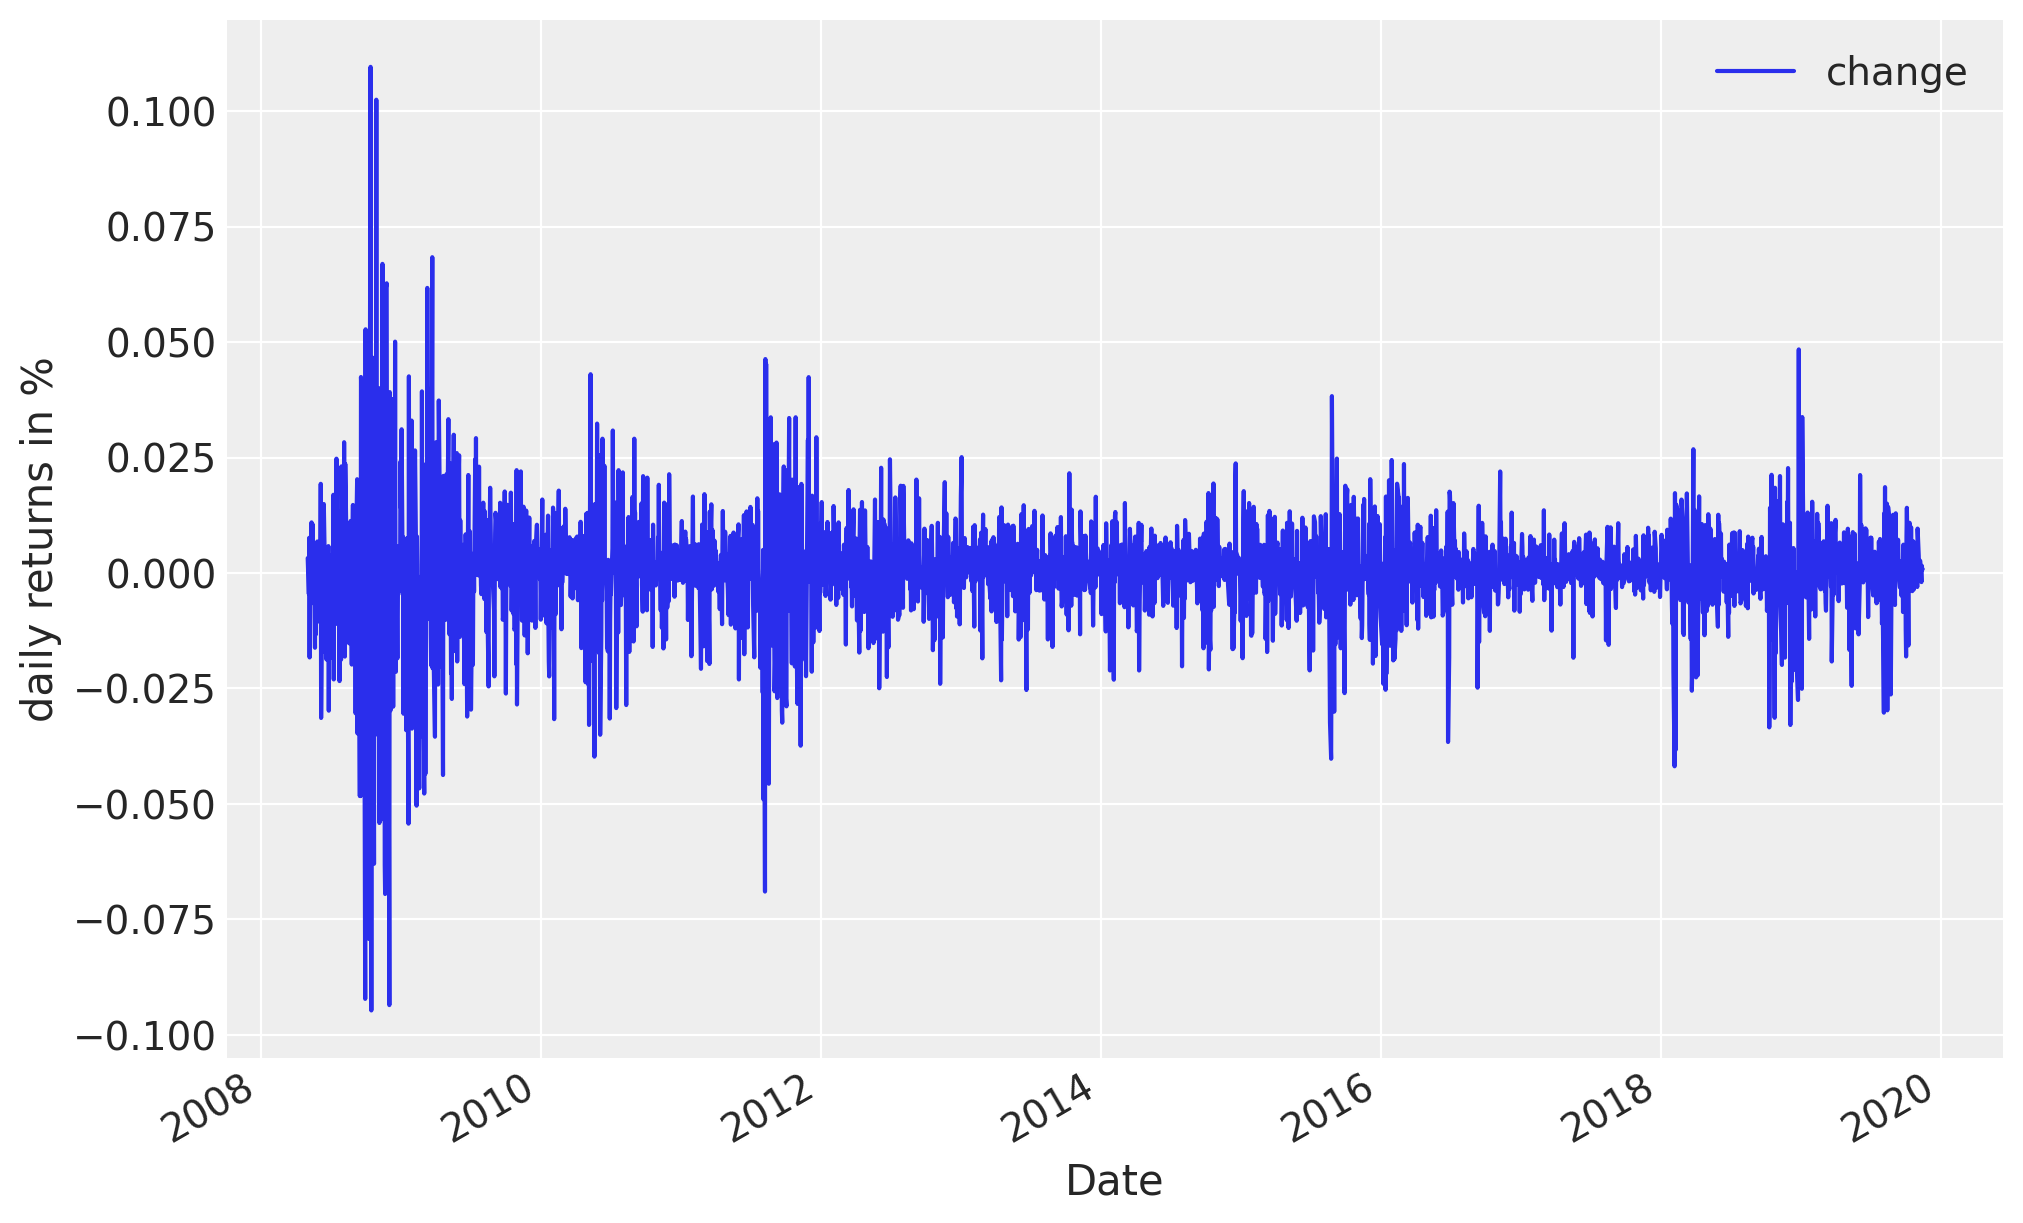

In [21]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    returns.plot(figsize=(10, 6))
    plt.ylabel("daily returns in %");

In [22]:
with pm.Model() as sp500_model:
    # The model remembers the datetime index with the name 'date'
    change_returns = pm.Data("returns", returns["change"], dims="date", export_index_as_coords=True)

    nu = pm.Exponential("nu", 1 / 10.0, testval=5.0)
    sigma = pm.Exponential("sigma", 2.0, testval=0.1)

    # We can now figure out the shape of variables based on the
    # index of the dataset
    s = pm.GaussianRandomWalk("s", sigma=sigma, dims="date")
    # instead of:
    # s = pm.GaussianRandomWalk('s', sigma, shape=len(returns))
    volatility_process = pm.Deterministic(
        "volatility_process", pm.math.exp(-2 * s) ** 0.5, dims="date"
    )

    r = pm.StudentT("r", nu=nu, sigma=volatility_process, observed=change_returns, dims="date")

In [23]:
sp500_model.RV_dims

{'returns': ('date',),
 's': ('date',),
 'volatility_process': ('date',),
 'r': ('date',)}

In [24]:
sp500_model.coords

{'date': DatetimeIndex(['2008-05-02', '2008-05-05', '2008-05-06', '2008-05-07',
                '2008-05-08', '2008-05-09', '2008-05-12', '2008-05-13',
                '2008-05-14', '2008-05-15',
                ...
                '2019-11-01', '2019-11-04', '2019-11-05', '2019-11-06',
                '2019-11-07', '2019-11-08', '2019-11-11', '2019-11-12',
                '2019-11-13', '2019-11-14'],
               dtype='datetime64[ns]', name='Date', length=2906, freq=None)}

In [25]:
with sp500_model:
    trace = pm.sample(2000, init="adapt_diag", return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, sigma, nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 249 seconds.


0, dim: date, 2906 =? 2906


The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: date, 2906 =? 2906
0, dim: date, 2906 =? 2906


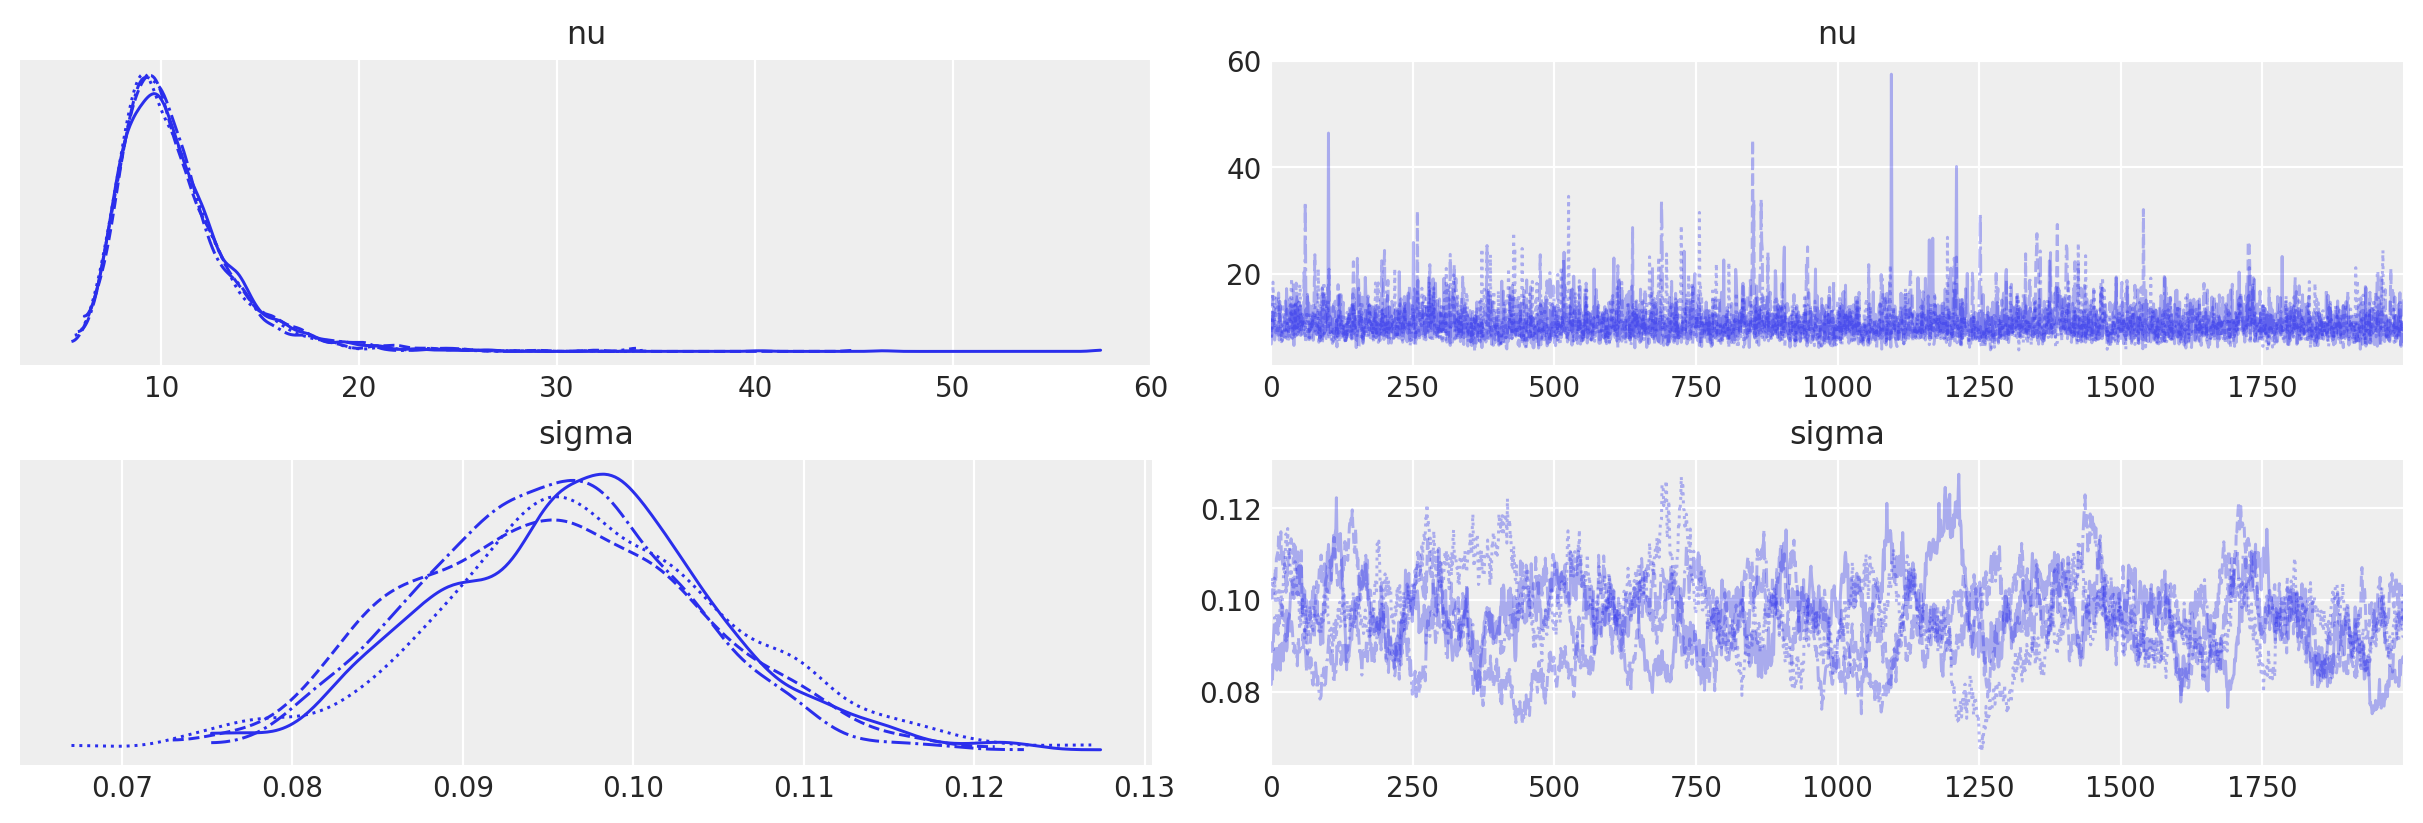

In [26]:
with sp500_model:
    az.plot_trace(trace, var_names=["nu", "sigma"]);

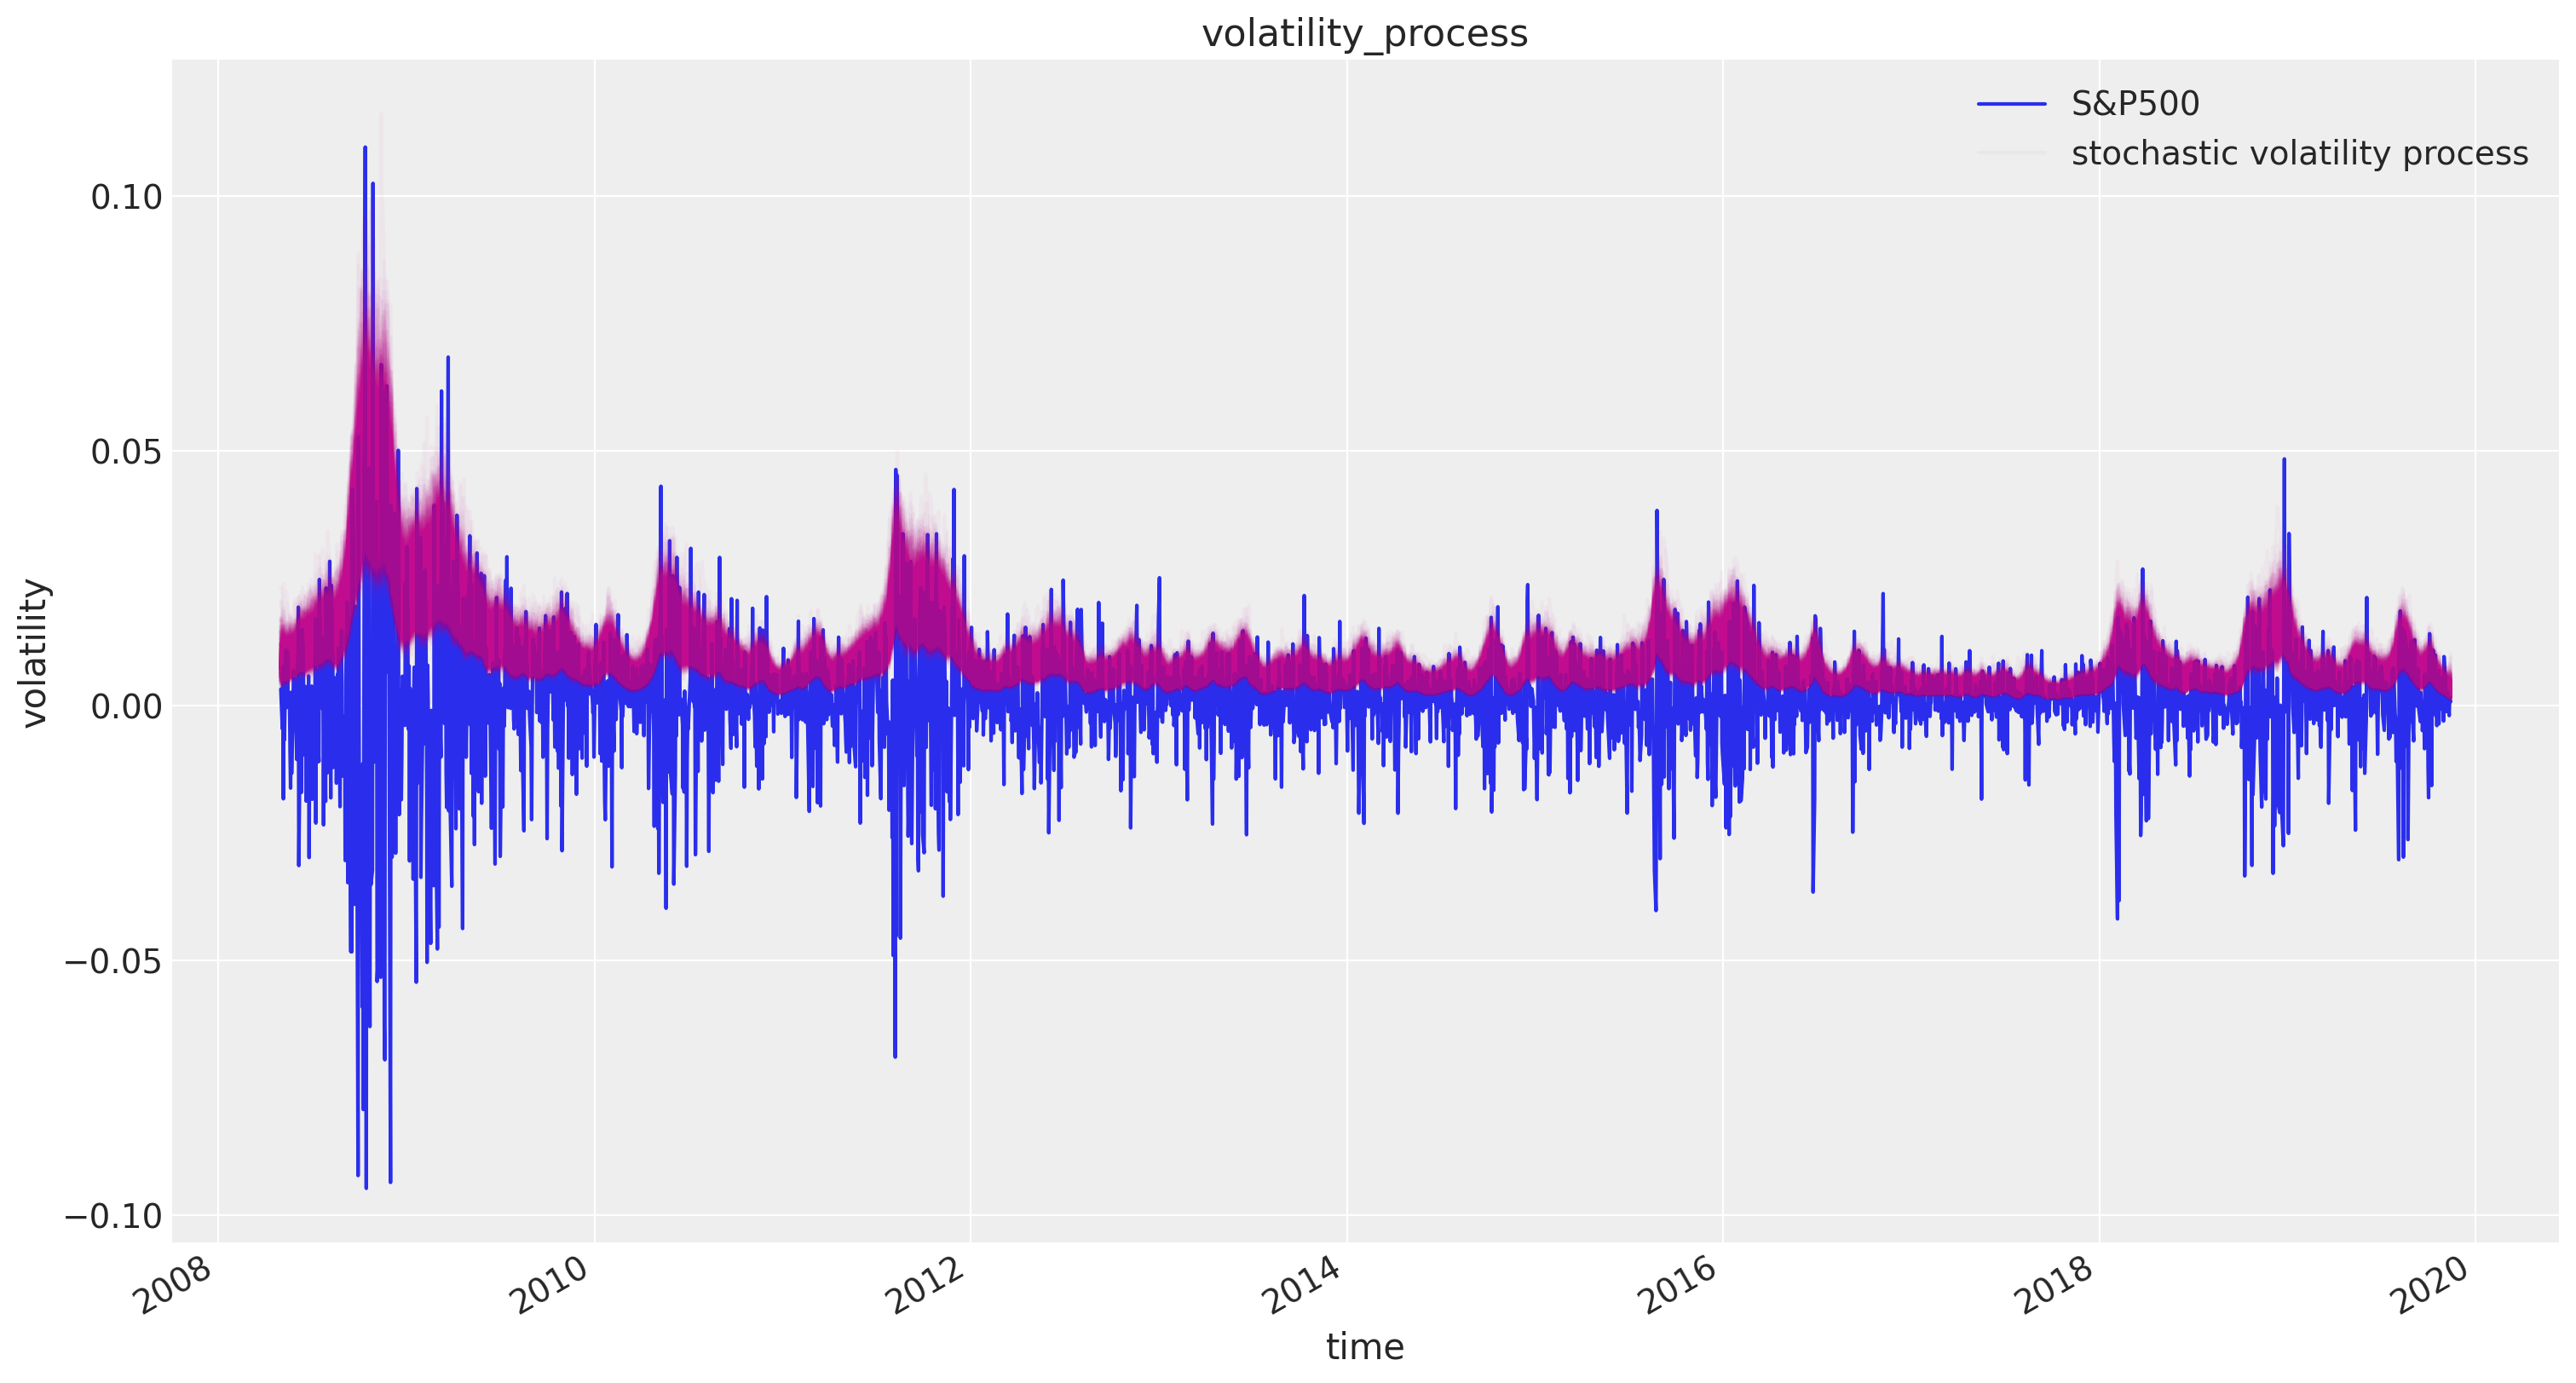

In [27]:
fig, ax = plt.subplots(figsize=(15, 8))
returns.plot(ax=ax)
ax.plot(returns.index, 1 / np.exp(trace["s", ::5].T), "C3", alpha=0.03)
ax.set(title="volatility_process", xlabel="time", ylabel="volatility")
ax.legend(["S&P500", "stochastic volatility process"], loc="upper right");

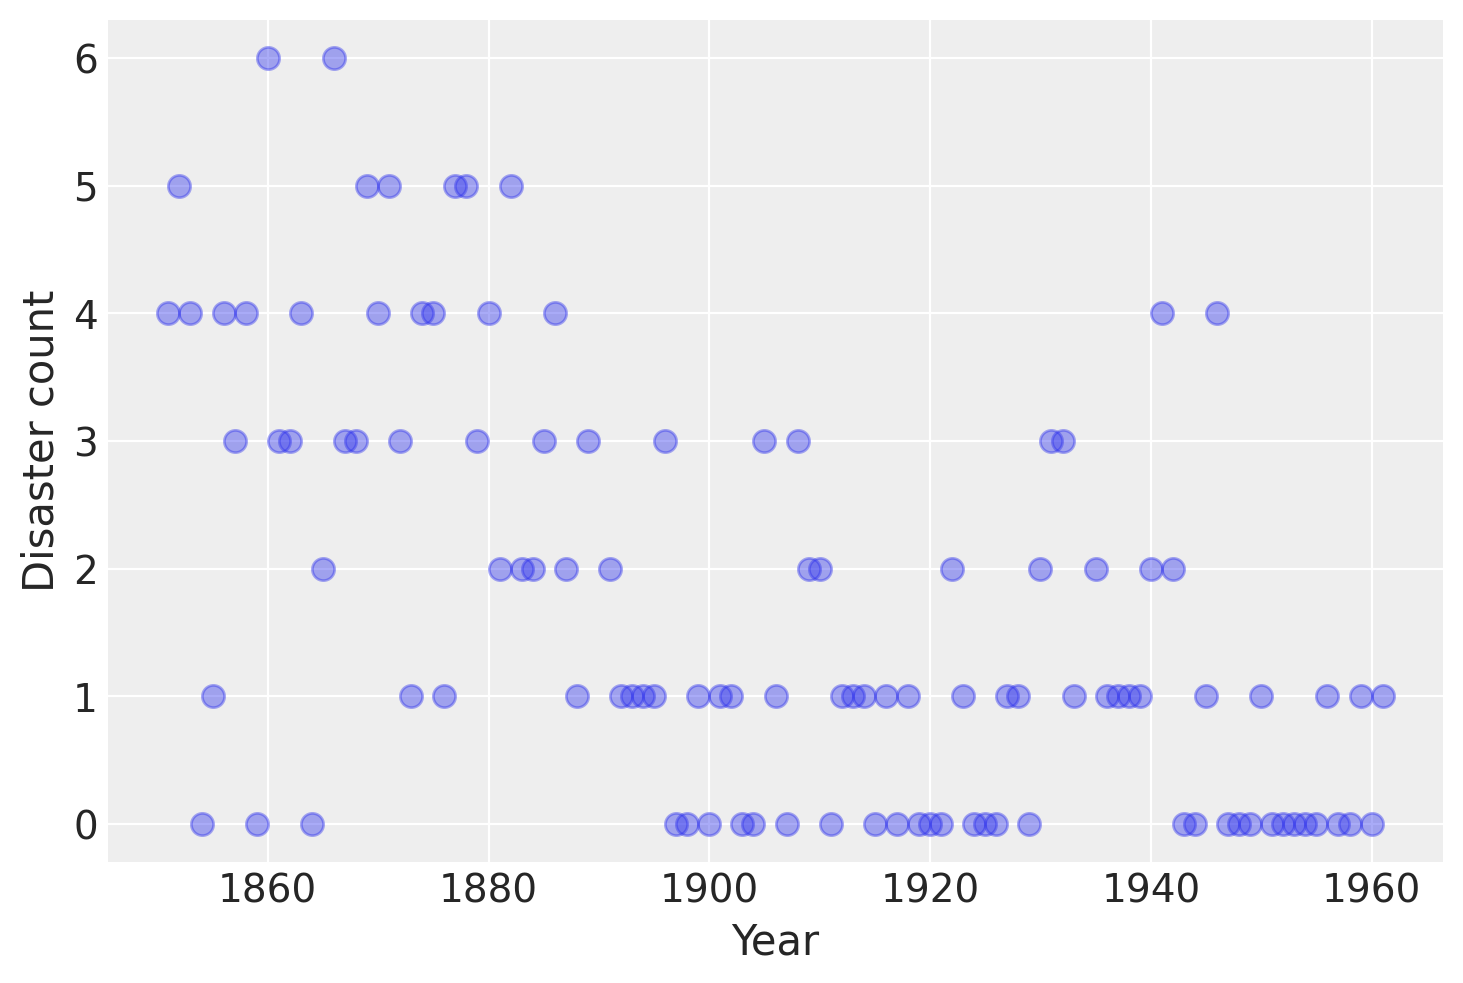

In [28]:
# fmt: off
disaster_data = pd.Series(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
    3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
    2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
    1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
    0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
    3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
    0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
)
# fmt: on
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Year");

In [29]:
with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform(
        "switchpoint", lower=years.min(), upper=years.max(), testval=1900
    )

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

/opt/anaconda3/envs/pymc3/lib/python3.8/site-packages/pymc3/model.py:1755: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [31]:
with disaster_model:
    trace = pm.sample(10000, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 21 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [32]:
with disaster_model:
    idata = az.from_pymc3(trace)

In [33]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

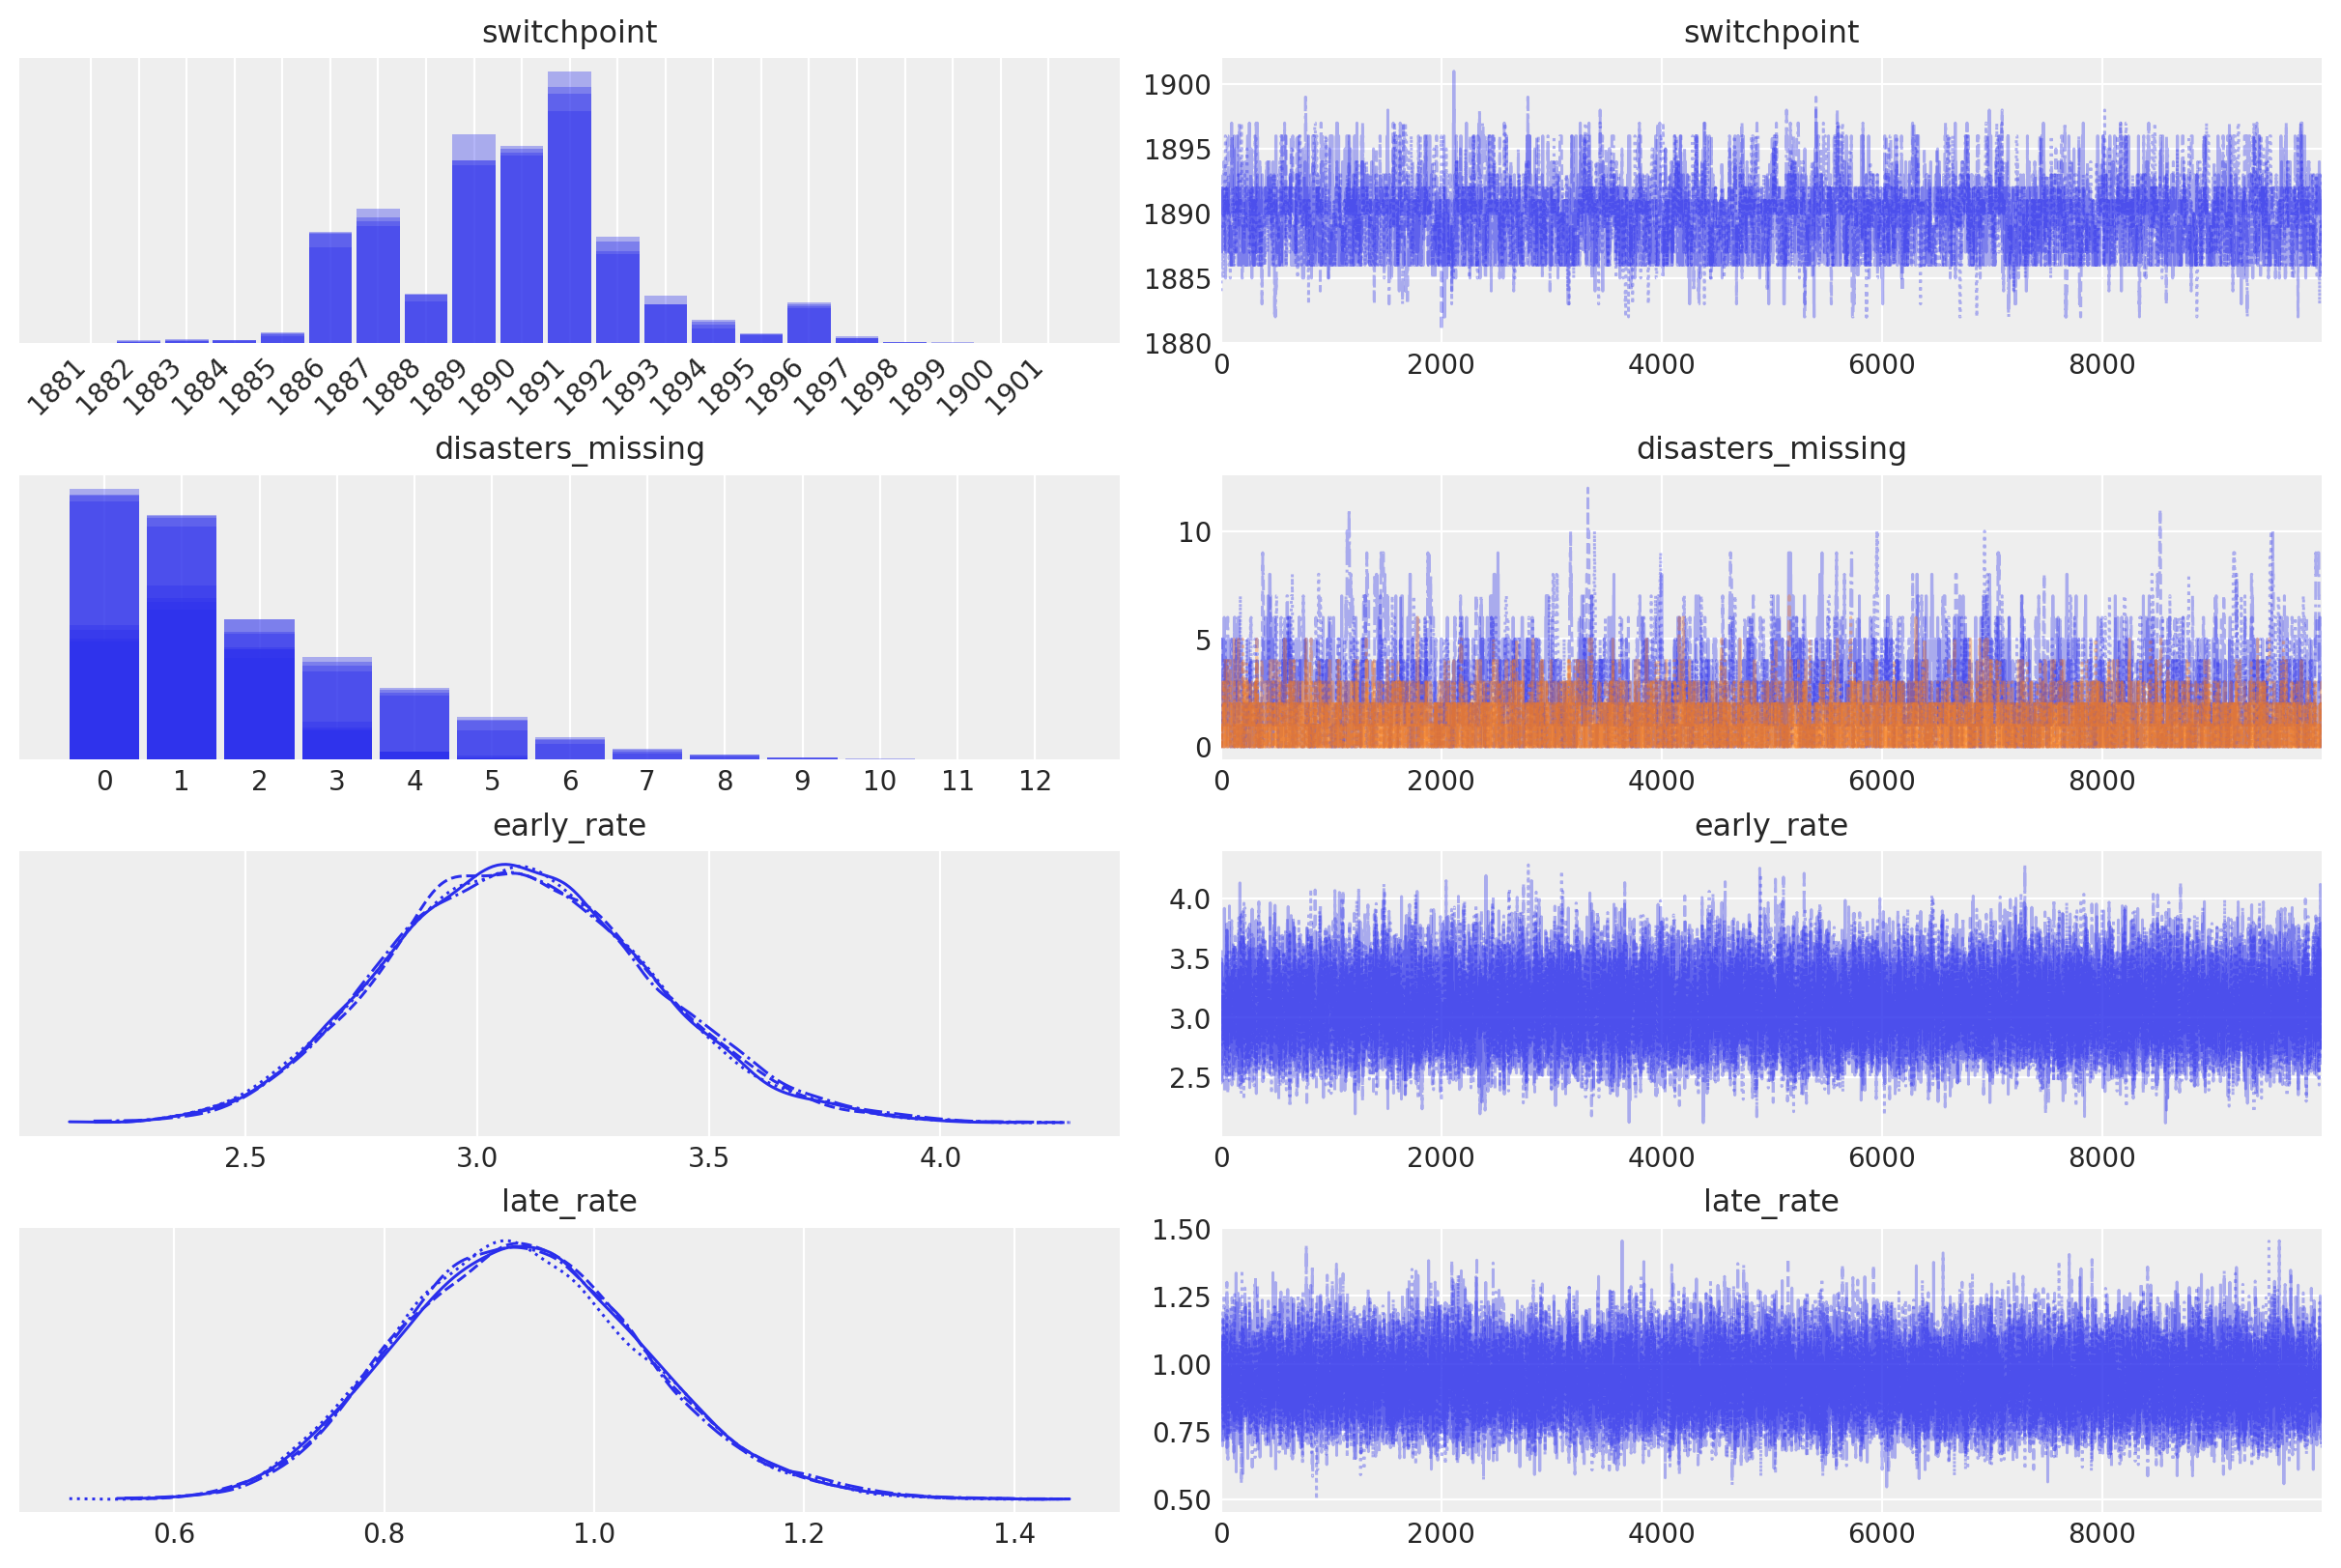

In [34]:
with disaster_model:
    axes_arr = az.plot_trace(trace)
plt.draw()
for ax in axes_arr.flatten():
    if ax.get_title() == "switchpoint":
        labels = [label.get_text() for label in ax.get_xticklabels()]
        ax.set_xticklabels(labels, rotation=45, ha="right")
        break
plt.draw()

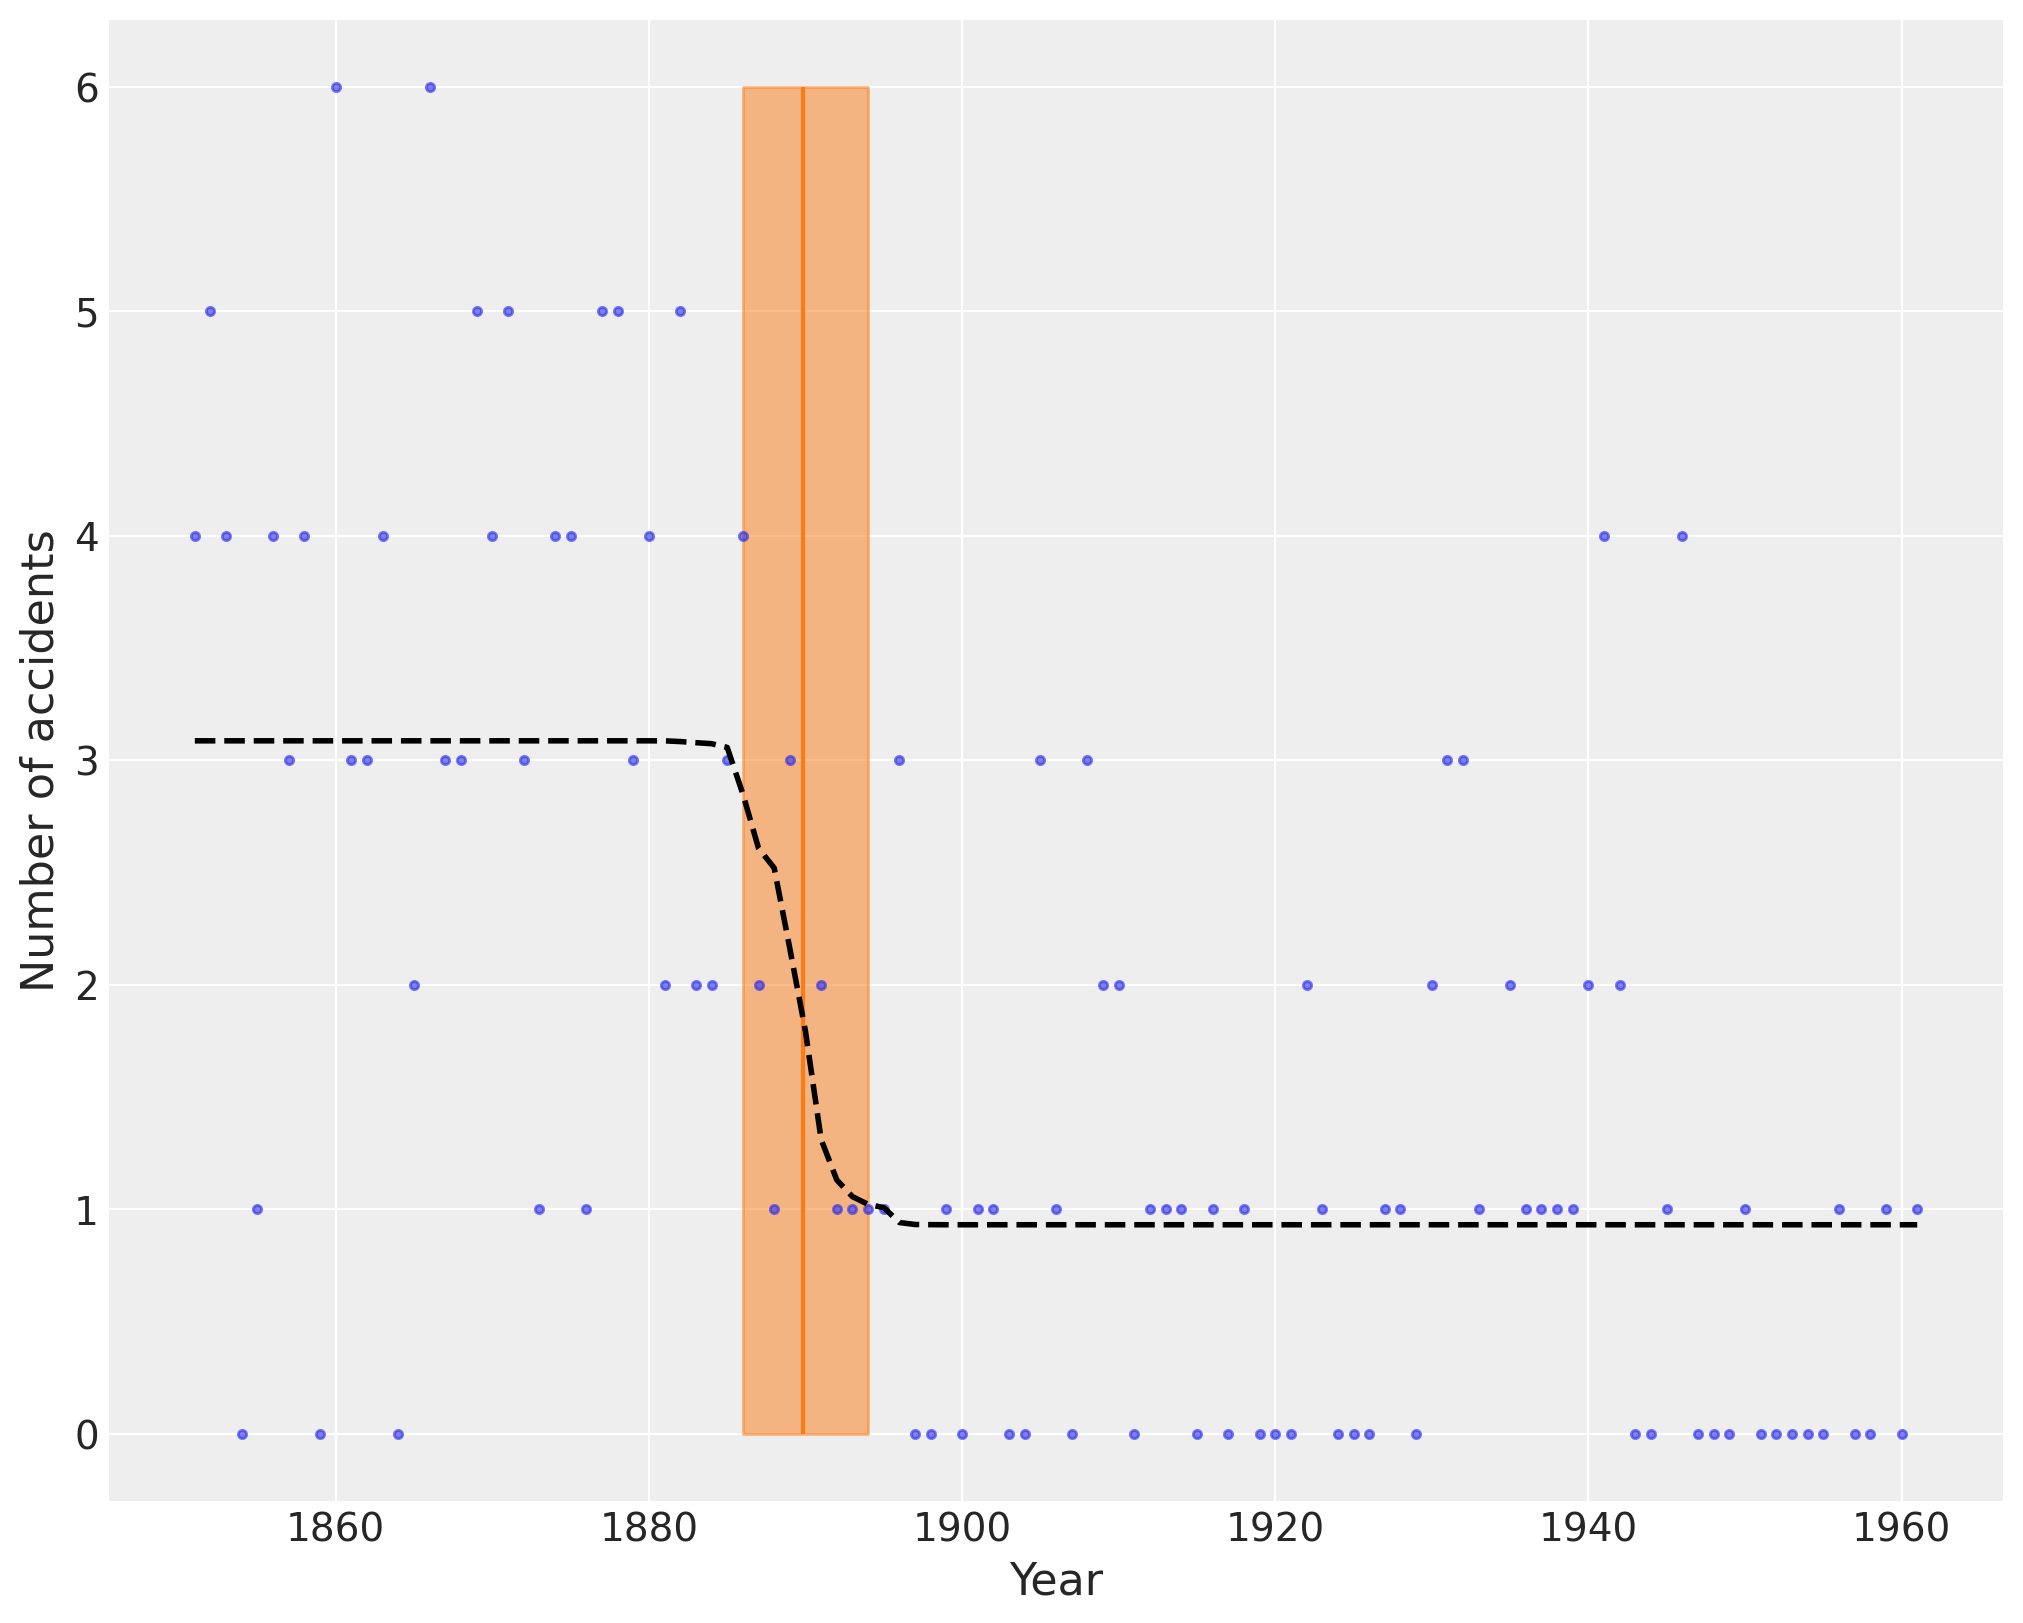

In [35]:
plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, ".", alpha=0.6)
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

plt.vlines(trace["switchpoint"].mean(), disaster_data.min(), disaster_data.max(), color="C1")
average_disasters = np.zeros_like(disaster_data, dtype="float")
for i, year in enumerate(years):
    idx = year < trace["switchpoint"]
    average_disasters[i] = np.mean(np.where(idx, trace["early_rate"], trace["late_rate"]))

sp_hpd = az.hdi(trace["switchpoint"])
plt.fill_betweenx(
    y=[disaster_data.min(), disaster_data.max()],
    x1=sp_hpd[0],
    x2=sp_hpd[1],
    alpha=0.5,
    color="C1",
)
plt.plot(years, average_disasters, "k--", lw=2);

In [36]:
import theano.tensor as tt

from theano.compile.ops import as_op


@as_op(itypes=[tt.lscalar], otypes=[tt.lscalar])
def crazy_modulo3(value):
    if value > 0:
        return value % 3
    else:
        return (-value + 1) % 3


with pm.Model() as model_deterministic:
    a = pm.Poisson("a", 1)
    b = crazy_modulo3(a)

In [41]:
import theano.tensor as tt

with pm.Model() as model:
    alpha = pm.Uniform('intercept', -100, 100)

    # Create custom densities
    beta = pm.DensityDist('beta', lambda value: -1.5 * tt.log(1 + value**2), testval=0)
    eps = pm.DensityDist('eps', lambda value: -tt.log(tt.abs_(value)), testval=1)

    # Create likelihood
    like = pm.Normal('y_est', mu=alpha + beta * X1, sigma=eps, observed=Y)

In [38]:
class Beta(pm.Continuous):
    def __init__(self, mu, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mu = mu
        self.mode = mu

    def logp(self, value):
        mu = self.mu
        return beta_logp(value - mu)


def beta_logp(value):
    return -1.5 * np.log(1 + (value) ** 2)


with pm.Model() as model:
    beta = Beta("slope", mu=0, testval=0)

In [39]:
# Convert X and Y to a pandas DataFrame
df = pd.DataFrame({"x1": X1, "x2": X2, "y": Y})

In [40]:
from pymc3.glm import GLM

with pm.Model() as model_glm:
    GLM.from_formula("y ~ x1 + x2", df)
    trace = pm.sample()

<ipython-input-40-c92c5b584cff>:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, x2, x1, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


In [43]:
from pymc3.glm.families import Binomial

df_logistic = pd.DataFrame({"x1": X1, "y": Y > np.median(Y)})

with pm.Model() as model_glm_logistic:
    GLM.from_formula("y ~ x1", df_logistic, family=Binomial())